# WG 6

Integrantes: 
- A´lvaro Zapata
- Diego Esteban
- Luis Quispe

In [1]:
import random
import pandas as pd
import numpy as np
from scipy.stats import norm

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
#from SyncRNG import SyncRNG
import numpy as np
import re
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy import linalg
from itertools import chain

#from SyncRNG import SyncRNG

from CTL.causal_tree_learn import CausalTree
from sklearn.model_selection import train_test_split
import plotnine as p
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [269]:
# Define a function which turn a list or vector-like object into a proper two
# dimensional column vector

def cvec(a):
    """ Turn a list or vector-like object into a proper column vector
    Input
    a: List or vector-like object, has to be a potential input for np.array()
    Output
    vec: two dimensional NumPy array, with the first dimension weakly greater
         than the second (resulting in a column vector for a vector-like input)
    """
    # Conver input into a two dimensional NumPy array
    vec = np.array(a, ndmin=2)

    # Check whether the second dimension is strictly greater than the first
    # (remembering Python's zero indexing)
    if vec.shape[0] < vec.shape[1]:
        # If so, transpose the input vector
        vec = vec.T

    # Return the column vector
    return vec


In [270]:
def get_cov(X, e, add_intercept=True, homoskedastic=False):
    """ Calculates OLS variance estimator based on X and residuals
    Inputs
    X: n by k matrix, RHS variables
    e: n by 1 vector or vector-like, residuals from an OLS regression
    add_intercept: Boolean, if True, adds an intercept as the first column of X
                   (and increases k by one)
    Outputs
    V_hat: k by k NumPy array, estimated covariance matrix
    """
    # Get the number of observations n and parameters k
    n, k = X.shape

    # Check whether an intercept needs to be added
    if add_intercept:
        # If so, add the intercept
        X = np.concatenate([np.ones(shape=(n,1)), X], axis=1)

        # Don't forget to increase k
        k = k + 1

    # Make sure the residuals are a proper column vector
    e = cvec(e)

    # Calculate X'X
    XX = X.T @ X

    # Calculate its inverse
    XXinv = linalg.inv(XX)

    # Check whether to use homoskedastic errors
    if homoskedastic:
        # If so, calculate the homoskedastic variance estimator
        V_hat = (1 / (n-k)) * XXinv * (e.T @ e)
    else:
        # Otherwise, calculate an intermediate object
        S = (e @ np.ones(shape=(1,k))) * X

        # Then, get the HC0 sandwich estimator
        V_hat = (n / (n-k)) * XXinv @ (S.transpose() @ S) @ XXinv

    # Return the result
    return V_hat

In [271]:
# Auxiliary function to computes adjusted p-values 
# following the Romano-Wolf method.
# For a reference, see http://ftp.iza.org/dp12845.pdf page 8
#  t.orig: vector of t-statistics from original model
#  t.boot: matrix of t-statistics from bootstrapped models


def romano_wolf_correction(t_orig, t_boot):
    abs_t_orig = np.absolute(t_orig)
    abs_t_boot = np.absolute(t_boot)
    abs_t_sorted = sorted(abs_t_orig, key = float, reverse=True)

    max_order = (-np.array(abs_t_orig)).argsort()
    rev_order = np.argsort(max_order)

    M = t_boot.shape[0]
    S = t_boot.shape[1]

    p_adj = list(np.repeat(0, S))
    p_adj[0] = np.mean(pd.DataFrame(abs_t_boot).apply(np.max, axis=1) > abs_t_sorted[0])

    for s in range(1,S):
        cur_index = max_order[s:S]
        p_init = np.mean(
            pd.DataFrame(abs_t_boot).T.iloc[cur_index].T.apply(np.max, axis=1) > abs_t_sorted[s])
        p_adj[s] = np.max(p_init, p_adj[s])

    aux = []
    for i in rev_order:
        aux.append(p_adj[i])

    p_adj = aux
    
    return(p_adj)

In [272]:
# Computes adjusted p-values for linear regression (lm) models.
#    model: object of lm class (i.e., a linear reg model)
#    indices: vector of integers for the coefficients that will be tested
#    cov.type: type of standard error (to be passed to sandwich::vcovHC)
#    num.boot: number of null bootstrap samples. Increase to stabilize across runs.
# Note: results are probabilitistic and may change slightly at every run. 
#
# Adapted from the p_adjust from from the hdm package, written by Philipp Bach.
# https://github.com/PhilippBach/hdm_prev/blob/master/R/p_adjust.R

def summary_rw_lm(model, indices='', cov_type="HC2", num_boot=10000):
    SyncRNG(seed = 123456)  

    # OLS without correction

    # Grab the original t values.
    ols = smf.ols(fmla, data=data).fit()
    ols = ols.summary2().tables[1].reset_index()
    summary = ols[ols['index'].isin(list(indices["index"]))]
    t_orig = summary['t']

    # Null resampling.
    # This is a trick to speed up bootstrapping linear models.
    # Here, we don't really need to re-fit linear regressions, which would be a bit slow.
    # We know that betahat ~ N(beta, Sigma), and we have an estimate Sigmahat.
    # So we can approximate "null t-values" by
    #  - Draw beta.boot ~ N(0, Sigma-hat) --- note the 0 here, this is what makes it a *null* t-value.
    #  - Compute t.boot = beta.boot / sqrt(diag(Sigma.hat))

    ols = smf.ols(fmla, data=data).fit(cov_type = cov_type)
    ols_exog = smf.ols(fmla, data=data).exog
    ols_res = smf.ols(fmla, data=data).fit().resid
    Sigma_hat = get_cov(ols_exog, ols_res, add_intercept=False)

    se_orig = pd.Series(np.sqrt(Sigma_hat.diagonal()))

    num_coef = len(se_orig)

    beta_boot = pd.DataFrame(
                np.random.multivariate_normal(
                mean=np.repeat(0, num_coef), cov=Sigma_hat, size=num_boot))

    t_boot = np.array(beta_boot.apply(lambda row: row / se_orig, axis=1))
    t_boot = t_boot.T[(len(ols_1)-len(t_orig)):len(ols_1)].T

    p_adj = romano_wolf_correction(t_orig, t_boot)
    result = summary[['index','Coef.','Std.Err.','P>|t|']]
    result.rename(columns={'P>|t|': 'Orig.p-value'}, inplace=True)
    result['Adj. p-value'] = p_adj

    return(result)

As with other chapters in this tutorial, the code below should still work by replacing the next snippet of code with a different dataset, provided that you update the key variables `treatment`, `outcome`, and `covariates` below. Also, please make sure to read the comments as they may be subtle differences depending on whether your dataset was created in a randomized or observational setting.

In [273]:
data = pd.read_csv("synthetic_data.csv" )

n = data.shape[0]
data

,schoolid,Z,Y,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
0,76,1,0.081602,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,76,1,-0.385869,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,76,1,0.398184,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,76,1,-0.175037,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,76,1,0.884583,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,1,0,0.423366,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10387,1,0,-0.197092,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10388,1,0,0.141698,2,15,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10389,1,0,-0.351565,5,4,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702


In [274]:
# Drop school id
DF = data.drop(labels= "schoolid", axis = 1)
DF

# Matrices

school_id = data["schoolid"]

school_mat = pd.get_dummies(school_id)

school_size = np.sum(school_mat)

# first regression

W =None

#Treatmnent variable 
T = DF["Z"]

#Outcome variable
Y = DF["Y"]
 
# 10 covariates
X_raw = DF.iloc[:, 2:12]


school_mat = pd.get_dummies(school_id) #PY

C1_exp = pd.get_dummies(X_raw["C1"])
XC_exp = pd.get_dummies(X_raw["XC"])

# X Covariates DF
  
X1 = X_raw.merge(C1_exp, left_index=True, right_index=True)
X = X1.merge(XC_exp, left_index=True, right_index=True)
X = X.drop(labels= ["C1","XC"], axis = 1)
X

,S3,C2,C3,X1,X2,X3,X4,X5,1_x,2_x,...,11,12,13,14,15,0,1_y,2_y,3_y,4_y
0,6,2,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,...,0,0,0,0,0,0,0,0,0,1
1,4,2,1,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,...,0,1,0,0,0,0,0,0,0,1
2,6,2,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,...,0,0,0,0,0,0,0,0,0,1
3,6,2,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,...,0,0,0,0,0,0,0,0,0,1
4,6,1,0,0.334544,0.648586,-1.310927,0.224077,-0.426757,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,7,2,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,...,0,0,0,0,0,0,0,0,1,0
10387,7,2,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,...,0,0,0,0,0,0,0,0,1,0
10388,2,1,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,...,0,0,0,0,1,0,0,0,1,0
10389,5,1,1,1.185986,-1.129889,1.009875,1.005063,-1.174702,0,0,...,0,0,0,0,0,0,0,0,1,0


In [275]:
treatment = T

outcome = Y

covariates = X

In [278]:
columns = covariates.columns # get varaible's names in a list
columns

Index([ 'S3',  'C2',  'C3',  'X1',  'X2',  'X3',  'X4',  'X5', '1_x', '2_x',
       '3_x', '4_x',     5,     6,     7,     8,     9,    10,    11,    12,
          13,    14,    15,     0, '1_y', '2_y', '3_y', '4_y'],
      dtype='object')

In [276]:
columns = covariates.columns # get varaible's names in a list

# From DataFrame to array 

X = covariates.values
Y = outcome.values
treatment = T.values

# CL-honest

cthl = CausalTree(honest=True, min_size=1, split_size=0.33)
cthl.fit(X, Y, treatment)
cthl.prune()

# plot
cthl.plot_tree(features=columns, filename="bin_tree_honest_1", show_effect=True, alpha = 0)

Degrees of freedom <= 0 for slice
invalid value encountered in double_scalars


In [279]:
# Valid only in randomized settings.
# Average difference-in-means within each ranking

# Formula y ~ 0 + ranking + ranking:w
fmla = 'y ~ 0 + C(ranking) + w:C(ranking)'
ols = smf.ols(fmla, data=data).fit(cov_type='HC2')
-
# Retrieve the interaction coefficients
ols_1 = ols.summary2().tables[1].reset_index()
ols_ate = ols_1.loc[ols_1["index"].str.contains("w:")].iloc[:,1:3]
ols_ate['method'] = "ols"
ols_ate['ranking'] = [f'Q{j}' for j in range(1,6)]
order = [2,3,0,1] # setting column's order
ols_ate = ols_ate[[ols_ate.columns[i] for i in order]]

SyntaxError: invalid syntax (3188100643.py, line 7)

In [280]:
# get train and test sample

train_x, val_x, train_y, val_y, train_t, val_t = train_test_split(X, y, treatment, random_state=724, shuffle=True,
                                                                          test_size=0.33)
# get honest/estimation portion
train_x, est_x, train_y, est_y, train_t, est_t = train_test_split(train_x, train_y, train_t, shuffle=True,
                                                                          random_state=724, test_size=0.5)

In [281]:
cthl_predict = cthl.predict(est_x)  # Predict tau 
num_leaves = len(np.unique(cthl_predict)) # number of leaves 

labels = [i for i in range(1,len(np.unique(cthl_predict)) + 1 ) ] # label by each leaf 

# Prediction grouped by each leaf

predict = pd.DataFrame({"predict": cthl_predict})
predict['leaves'] = pd.Categorical(predict.predict)
predict['leaves'] = predict['leaves'].cat.rename_categories(labels)

In [282]:
#CAUSAL TREE
predict

,predict,leaves
0,0.350011,7
1,0.307291,5
2,0.307291,5
3,0.307291,5
4,0.307291,5
...,...,...
3476,0.307291,5
3477,0.307291,5
3478,0.290658,4
3479,0.290658,4


## Causal Forest 

In [ ]:
#!pip install econml

In [283]:
import econml
# Main imports
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
from sklearn.linear_model import MultiTaskLassoCV
# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from econml.grf import RegressionForest
%matplotlib inline
import patsy
import seaborn as sns

In [284]:
# Preparing data to fit a causal forest

fmla = '0+S3+C2+C3+X1+X2+X3+X4+X5'
desc = patsy.ModelDesc.from_formula(fmla)
desc.describe()
matrix = patsy.dmatrix(fmla, data, return_type = "dataframe")


# Estimate a causal forest.
est2 = CausalForestDML(model_t=RegressionForest(),
                       model_y=RegressionForest(),
                       n_estimators=200, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)

est2.tune(Y, T, X=X, W=W)
est2.fit(Y, T, X=X, W=W)

In [285]:
# Get residuals  and propensity 
residuals = est2.fit(Y, T, X=X, W=W, cache_values=True).residuals_
T_res = residuals[1]
e_hat = T - T_res 

# T = beta_hat*X + e , beta_hat*X = T_hat = T-e

In [286]:
Prop = pd.DataFrame({"p_score":e_hat, "Treatment":T})

<AxesSubplot:xlabel='p_score', ylabel='Count'>

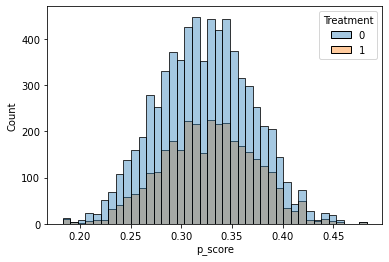

In [287]:
#Propensity score 

sns.histplot(data=Prop, x="p_score", hue="Treatment", bins=40, alpha = 0.4)

Having fit a non-parametric method such as a causal forest, a researcher may (incorrectly) start by looking at the distribution of its predictions of the treatment effect. One might be tempted to think: "if the histogram is concentrated at a point, then there is no heterogeneity; if the histogram is spread out, then our estimator has found interesting heterogeneity." However, this may be false.

In [288]:
tau_hat = est2.effect(X=X) # tau(X) estimates

In [289]:
tau_hat

array([0.2789226 , 0.25438366, 0.26726699, ..., 0.16598715, 0.18083885,
       0.16767039])

Text(0.5, 1.0, 'CATE estimates')

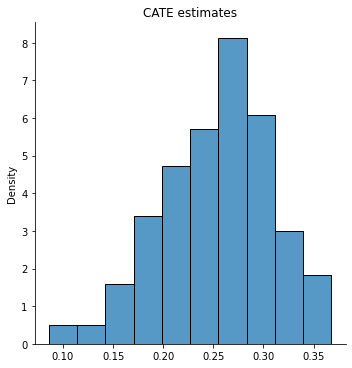

In [290]:
# Do not use this for assessing heterogeneity. See text above.
sns.displot( tau_hat, stat="density", bins = 10)
plt.title("CATE estimates")

In [291]:
est2.feature_importances()

array([2.40859646e-02, 4.11597080e-02, 3.85587206e-02, 1.80816253e-01,
       1.16224184e-01, 5.39041344e-02, 7.84319128e-02, 1.88431916e-01,
       1.36390574e-03, 5.84471784e-03, 0.00000000e+00, 5.80352845e-02,
       7.48711425e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.34241576e-03,
       0.00000000e+00, 1.52118210e-03, 5.17876423e-04, 1.72216483e-04,
       3.19162894e-02, 1.77630801e-03, 1.55598762e-01, 9.81113363e-03])

In [292]:
importance = pd.DataFrame({"covariaties" : list(covariates.columns), "values" : est2.feature_importances()})

In [293]:
importance.sort_values('values', ascending = False)

,covariaties,values
7,X5,0.188432
3,X1,0.180816
26,3_y,0.155599
4,X2,0.116224
6,X4,0.078432
11,4_x,0.058035
5,X3,0.053904
1,C2,0.041160
2,C3,0.038559
24,1_y,0.031916


#### Data-driven subgroups

Just as with causal trees, we can use causal forests to divide our observations into subgroups. In place of leaves, we'll rank observation into (say) quintiles according to their estimated CATE prediction; see, e.g., [Chernozhukov, Demirer, Duflo, Fernández-Val (2020)](https://arxiv.org/abs/1712.04802) for similar ideas.

There's a subtle but important point that needs to be addressed here. As we have mentioned before, when predicting the conditional average treatment effect $\tau(X_i)$ for observation $i$ we should in general avoid using a model that was fitted using observation $i$. This sort of sample splitting (which we called **honesty** above) is one of the required ingredients to get unbiased estimates of the CATE using the methods described here. However, when ranking estimates of two observations $i$ and $j$, we need something a little stronger: we must ensure that the model was not fit using _either_ $i$ _or_ $j$'s data. 

One way of overcoming this obstacle is simple. First, divide the data into $K$ folds (subsets). Then, cycle through the folds, fitting a CATE model on $K-1$ folds. Next, for each held-out fold, _separately_ rank the unseen observations into $Q$ groups based on their prediction  (i.e., if $Q=5$, then we rank observations by estimated CATE into "top quintile", "second quintile", and so on). After concatenating the independent rankings together, we can study the differences in observations in each rank-group. 

[This gist](https://gist.github.com/halflearned/bea4e5137c0c81fd18a75f682da466c8) computes the above for `grf`, and it should not be hard to modify it so as to replace forests by any other non-parametric method. However, for `grf` specifically, there's a small trick that allows us to obtain a valid ranking: we can pass a vector of fold indices to the argument `clusters` and rank observations within each fold. This works because estimates for each fold ("cluster")   trees are computed using trees that were not fit using observations from that fold. Here's how to do it. 


In [294]:
fmla = '0+S3+C2+C3+X1+X2+X3+X4+X5'
desc = patsy.ModelDesc.from_formula(fmla)
matrix = patsy.dmatrix(fmla, data, return_type = "dataframe")




In [295]:

def cluster_causal_forest(Y,T, X, W,  cluster):        
        
        base = pd.concat([Y,T], axis = 1)
        
        for i in range(cluster):
        
            index=range(X.shape[0]) 
            a = np.array_split(np.array(index),cluster)[i]  ## split index
            
            Y = base.drop(base.iloc[list(a),:].index).iloc[:,0]
            T = base.drop(base.iloc[list(a),:].index).iloc[:,1]
            XX = X.drop(X.iloc[list(a),:].index)
            causal = CausalForestDML(model_t=RegressionForest(),
                       model_y=RegressionForest(),
                       n_estimators=200, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)
            causal.fit(Y, T, X=XX, W=W)
            
            tau_hat = causal.effect(X=X.iloc[list(a),:]) # tau(X) estimates using validation data
            vector = i*np.ones( len(list(a)) ) + 1
            globals()[f'data_{i}'] = pd.DataFrame({"tau_hat":tau_hat, "Cluster":vector})
                                                    
        
       
        tau_predict = data_0.copy()

        for k in range(1,10):
            tau_predict = tau_predict.append(globals()[f'data_{k}'] , ignore_index=True)
            
        
        
        return tau_predict

In [296]:
type(outcome)

pandas.core.series.Series

In [297]:
# Valid randomized data and observational data with unconfoundedness+overlap.
# Note: read the comments below carefully. 
# In randomized settings, do not estimate forest.e and e.hat; use known assignment probs.

#
# Prepare dataset
fmla = '0+S3+C2+C3+X1+X2+X3+X4+X5'
desc = patsy.ModelDesc.from_formula(fmla)
matrix = patsy.dmatrix(fmla, data, return_type = "dataframe")


# Number of rankings that the predictions will be ranking on 
# (e.g., 2 for above/below median estimated CATE, 5 for estimated CATE quintiles, etc.)
num_rankings = 5  

# Prepare for data.splitting
# Assign a fold number to each observation.
# The argument 'clusters' in the next step will mimick K-fold cross-fitting.
num_folds = 10

# Estimate a causal forest.

tau_hat_cluster = cluster_causal_forest(outcome, T, covariates , W,  cluster = num_folds)

data['ranking'] = np.nan

for i in range(1,num_folds+1):
    split = tau_hat_cluster.Cluster == i
    index = tau_hat_cluster[split].index
    tau_quantile = np.quantile(tau_hat_cluster[split].iloc[:,0], list(np.arange(0,1.1,0.2)))
    labels =[i for i in range(1,6)]
    data.loc[index , ["ranking"]] = pd.cut(tau_hat_cluster[split]["tau_hat"], 
                                               tau_quantile , right=False, labels=labels)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [ ]:
data

In [ ]:
covariates

In [300]:
# Valid only in randomized settings.
# Average difference-in-means within each ranking

# Formula y ~ 0 + ranking + ranking:w
fmla = 'Y ~ 0 + C(ranking) + W:C(ranking)'
ols = smf.ols(fmla, data=data).fit(cov_type='HC2')


ValueError: negative dimensions are not allowed

In [301]:

# Retrieve the interaction coefficients
ols_1 = ols.summary2().tables[1].reset_index()
ols_ate = ols_1.loc[ols_1["index"].str.contains("W:")].iloc[:,1:3]
ols_ate['method'] = "ols"
ols_ate['ranking'] = [f'Q{j}' for j in range(1,6)]
order = [2,3,0,1] # setting column's order
ols_ate = ols_ate[[ols_ate.columns[i] for i in order]]

AttributeError: 'DataFrame' object has no attribute 'summary2'

In [302]:
ols_ate.rename({'Coef.': 'Estimate', 'Std.Err.': 'se'}, axis=1, inplace = True) 
ols_ate

,method,ranking,Estimate,se
0,NaN,Q1,NaN,NaN
1,NaN,Q2,NaN,NaN
2,NaN,Q3,NaN,NaN
3,NaN,Q4,NaN,NaN
4,NaN,Q5,NaN,NaN


In [303]:
# Computing AIPW scores.
tau_hat = est2.effect(X=X) #E[Y|X]

residuals = est2.fit(Y, T, X=X, W=W, cache_values=True).residuals_
T_res = residuals[1]
e_hat = T - T_res  # P[W=1|X]

Y_res = residuals[0]
m_hat = Y - Y_res # E[Y|X]


# Estimating mu.hat(X, 1) and mu.hat(X, 0) for obs in held-out sample
# Note: to understand this, read equations 6-8 in this vignette:
# https://grf-labs.github.io/grf/articles/muhats.html
mu_hat0 = m_hat - e_hat * tau_hat        # E[Y|X,W=0] = E[Y|X] - e(X)*tau(X)
mu_hat1 = m_hat + (1 - e_hat) * tau_hat  # E[Y|X,W=1] = E[Y|X] + (1 - e(X))*tau(X)

# AIPW scores
data['aipw_scores'] = tau_hat + T / e_hat * (Y -  mu_hat1) - (1 - T) / (1 - e_hat) * (Y -  mu_hat0)

fmla = 'aipw_scores ~ 0 + C(ranking)'
ols = smf.ols(fmla,data).fit(cov_type='HC2')

# Retrieve the interaction coefficients
ols = ols.summary2().tables[1].reset_index()
forest_ate = ols.loc[ols["index"].str.contains("ranking")].iloc[:,1:3]
forest_ate['method'] = "apiw"
forest_ate['ranking'] = [f'Q{j}' for j in range(1,6)]
order = [2,3,0,1] # setting column's order
forest_ate = forest_ate[[forest_ate.columns[i] for i in order]]
forest_ate.rename({'Coef.': 'Estimate', 'Std.Err.': 'se'}, axis=1, inplace = True) 
forest_ate

,method,ranking,Estimate,se
0,apiw,Q1,0.295245,0.025158
1,apiw,Q2,0.271286,0.024609
2,apiw,Q3,0.237506,0.024541
3,apiw,Q4,0.246723,0.024219
4,apiw,Q5,0.217280,0.025505


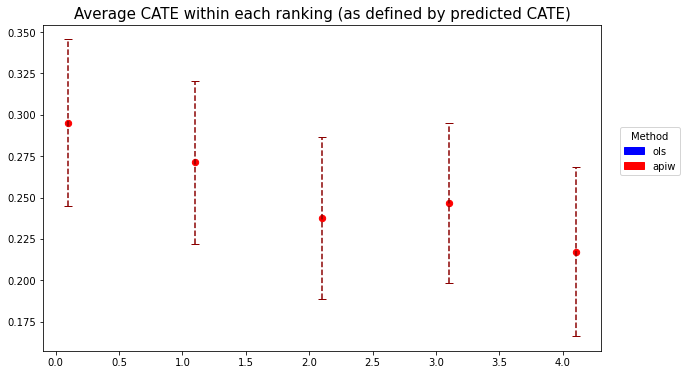

In [304]:
# Concatenate the two results.
res = forest_ate

# Plotting the point estimate of average treatment effect 
# and 95% confidence intervals around it.
# Define figure, axes, and plot
fig, ax = plt.subplots(figsize=(10, 6))



ax.scatter(x=np.arange(0.1,5,1), 
         marker='o', s=40, 
         y=res[res.method == "apiw"]['Estimate'], color = "red")



eb2 = plt.errorbar(x=np.arange(0.1,5,1), y=res[res.method == "apiw"]['Estimate'],
            yerr= 2*res[res.method == "apiw"]['se'],
            color = 'darkred', ls='', capsize = 4)
eb2[-1][0].set_linestyle('--')

# Set title & labels
plt.title('Average CATE within each ranking (as defined by predicted CATE)',fontsize=15)

# add legend

red_patch = mpatches.Patch(color='red', label='apiw')

plt.legend(title = "Method", handles=[blue_patch,red_patch],  bbox_to_anchor=(1.15, 0.7))
    
plt.show()


When there isn't much detectable heterogeneity, the plot above can end up being non-monotonic. This can mean that the number of observations is too small for us to be able to detect subgroups with relevant differences in treatment effect.

<font size=1>
As an exercise, try running the previous two snippets on few data points (e.g., the first thousand observations only). You will likely see the "non-monotonicity" phenomenon just described.
</font>

Next, as we did for leaves in a causal tree, we can test e.g., if the prediction for groups 2, 3, etc. are larger than the one in the first group. Here's how to do it based on a difference-in-means estimator. Note the Romano-Wolf multiple-hypothesis testing correction.

Here's how to do it for AIPW-based estimates, again with Romano-Wolf correction for multiple hypothesis testing. 

In [305]:
#! pip install syncrng
from SyncRNG import SyncRNG


In [306]:
# Valid in randomized and observational settings with unconfoundedness+overlap.

# Using AIPW scores computed above

fmla = 'aipw_scores ~  1 + C(ranking)'
ols = smf.ols(fmla, data=data).fit()
ols.summary2()

# Retrieve the interaction coefficients
ols_1 = ols.summary2().tables[1].reset_index()
interact = ols_1.loc[1:num_rankings +1 ,:]
forest_ate = summary_rw_lm(ols, indices=interact)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [307]:
forest_ate['ranking'] = [f'Rank {j} - Rank 1' for j in range(2,6)]
order = [5,1,2,3,4] # setting column's order
forest_ate = forest_ate[[forest_ate.columns[i] for i in order]]
forest_ate.rename({'Coef.': 'Estimate', 'Std.Err.': 'se', 'ranking': 'Comparative'}, axis=1, inplace = True) 
forest_ate




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Comparative,Estimate,se,Orig.p-value,Adj. p-value
1,Rank 2 - Rank 1,-0.023959,0.035064,0.494445,0.4914
2,Rank 3 - Rank 1,-0.057739,0.035124,0.100234,0.2380
3,Rank 4 - Rank 1,-0.048522,0.034943,0.164989,0.2759
4,Rank 5 - Rank 1,-0.077964,0.035193,0.026757,0.0921


In [309]:
columns

Index([ 'S3',  'C2',  'C3',  'X1',  'X2',  'X3',  'X4',  'X5', '1_x', '2_x',
       '3_x', '4_x',     5,     6,     7,     8,     9,    10,    11,    12,
          13,    14,    15,     0, '1_y', '2_y', '3_y', '4_y'],
      dtype='object')

In [310]:
columns= ['S3',  'C2',  'C3',  'X1',  'X2',  'X3',  'X4',  'X5', '1_x', '2_x',
       '3_x', '4_x',     '5',     '6',     '7',     '8',     '9',    '10',    '11',    '12',
      '13',    '14',    '15',     '0', '1_y', '2_y', '3_y', '4_y']

In [311]:
df = pd.DataFrame()

for var_name in columns:
    form2 = var_name + " ~ " + "0" + "+" + "C(ranking)"
    ols = smf.ols(formula=form2, data=data).fit(cov_type = 'HC2').summary2().tables[1].iloc[:, 0:2]
    
    

SyntaxError: invalid syntax (<unknown>, line 1)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[Text(0.5, 0, 'Q1'),
 Text(1.5, 0, 'Q2'),
 Text(2.5, 0, 'Q3'),
 Text(3.5, 0, 'Q4'),
 Text(4.5, 0, 'Q5')]

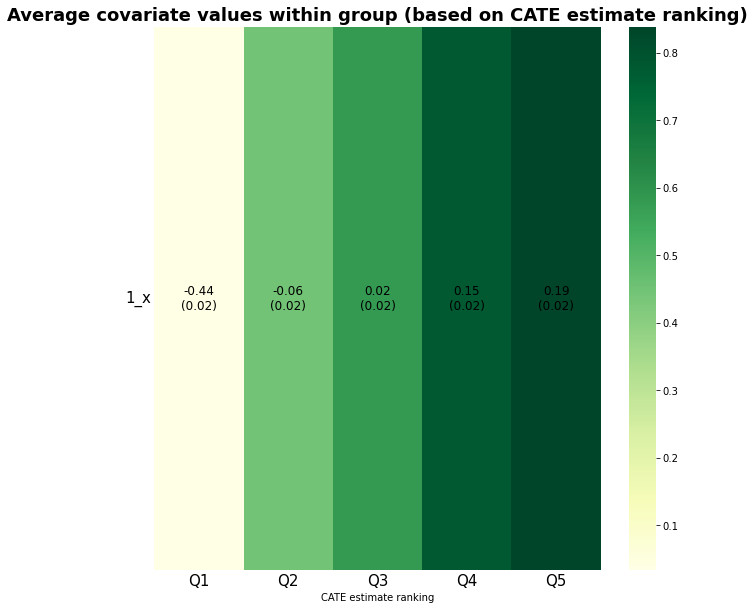

In [312]:

    # Retrieve results
    toget_index = ols["Coef."]
    index = toget_index.index
    cova1 = pd.Series(np.repeat(var_name,num_rankings), index = index, name = "covariate")
    avg = pd.Series(ols["Coef."], name="avg")
    stderr = pd.Series(ols["Std.Err."], name = "stderr")
    ranking = pd.Series(np.arange(1,num_rankings+1), index = index, name = "ranking")
    scaling = pd.Series(norm.cdf((avg - np.mean(avg))/np.std(avg)), index = index, name = "scaling")
    data2 = pd.DataFrame(data=covariates, columns= columns)
    variation1= np.std(avg) / np.std(data2[var_name])
    variation = pd.Series(np.repeat(variation1, num_rankings), index = index, name = "variation")
    labels = pd.Series(round(avg,2).astype('str') + "\n" + "(" + round(stderr, 2).astype('str') + ")", index = index, name = "labels")
    


# Tally up results
    df1 = pd.DataFrame(data = [cova1, avg, stderr, ranking, scaling, variation, labels]).T
    df = df.append(df1)
    
# a small optional trick to ensure heatmap will be in decreasing order of 'variation'
df = df.sort_values(by = ["variation", "covariate"], ascending = False)

df = df.iloc[0:(8*num_rankings), :]
df1 = df.pivot(index = "covariate", columns = "ranking", values = ["scaling"]).astype(float)
labels =  df.pivot(index = "covariate", columns = "ranking", values = ["labels"]).to_numpy()

# plot heatmap
ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df1, 
                 annot=labels,
                 annot_kws={"size": 12, 'color':"k"},
                 fmt = '',
                 cmap = "YlGn",
                 linewidths=0,
                 xticklabels = ranking)
plt.tick_params( axis='y', labelsize=15, length=0, labelrotation=0)
plt.tick_params( axis='x', labelsize=15, length=0, labelrotation=0)
plt.xlabel("CATE estimate ranking", fontsize= 10)
plt.ylabel("")
ax.set_title("Average covariate values within group (based on CATE estimate ranking)", fontsize=18, fontweight = "bold")
(ax.set_xticklabels(["Q1", "Q2", "Q3", "Q4","Q5"], size=15))